In [25]:
import pandas as pd
import datasets
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [5]:
embs_df = pd.read_parquet('embs.parquet')

In [9]:
emb_map = {row.session_folder: row.embedding for row in embs_df[['session_folder', 'embedding']].itertuples()}

In [12]:
def prnu_similarity(emb1, emb2):
    if emb1.shape != emb2.shape:
        print(f"ERROR different shape {emb1.shape} != {emb2.shape}")
        return 0
    emb1 = emb1.flatten()
    emb2 = emb2.flatten()
    emb1 -= emb1.mean()
    emb2 -= emb2.mean()
    return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))

prnu_similarity(embs_df.embedding.iloc[0], embs_df.embedding.iloc[1])

-0.002215669024735689

In [6]:
%%time
ds_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/hackathon_2025-07_camera_fingerprint/'
ds = datasets.load_from_disk(ds_uri)
len(ds)

CPU times: user 2.77 s, sys: 2.19 s, total: 4.96 s
Wall time: 7.17 s


64823

In [7]:
important_columns = [
    'subject_name', 'session_folder', 'photo_name', # user / session / frame ids
    'gif_link', 'file_timestamp_within_session_ms', 'frame_number', # frame info
    'device_metadata', # json string with all the device metadata info
    'camera_device_id', 'camera_label', 'user_device_camera', # camera info parsed from device metadata
    'split', # test / train split
    'os_name', 'os_version', # os info
    'img_w', 'img_h', 'img_wh', # img info
    'img_raw', # jpg bytes of image

]
df = ds.select_columns(important_columns).to_pandas()

In [18]:
df = df[df.img_wh != '2x2']
df.head(3)

,subject_name,session_folder,photo_name,gif_link,file_timestamp_within_session_ms,frame_number,device_metadata,camera_device_id,camera_label,user_device_camera,split,os_name,os_version,img_w,img_h,img_wh,img_raw
0,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,0.0,0.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,299.0,6.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,599.0,12.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [67]:
cameras_per_user = df.groupby('subject_name').user_device_camera.nunique().sort_values()
viable_users = cameras_per_user[cameras_per_user > 1].index.to_list()
viable_users[:3]

['daniele@keyless.io', 'evgjeni.larushi@keyless.io', 'dpanic']

In [19]:
def calculate_scores(df, emb_map):
    rows = []

    # cache similar
    scores = {}

    for sess_enroll, enrl_df in tqdm(df.groupby('session_folder')):
        for sess_auth, auth_df in df.groupby('session_folder'):
            # enrl_imgs = get_session(ds, df, sess_enroll)["img_raw"]
            # auth_imgs = get_session(ds, df, sess_auth)["img_raw"]

            if sess_enroll == sess_auth:
                continue

            enrl_row = enrl_df.iloc[0]
            auth_row = auth_df.iloc[0]

            if enrl_row.subject_name != auth_row.subject_name:
                continue

            combo_idx = tuple(sorted([sess_enroll, sess_auth]))
            if combo_idx in scores:
                sim_score = scores[combo_idx]
            else:
                enrl_emb = emb_map[sess_enroll]
                auth_emb = emb_map[sess_auth]
                sim_score = prnu_similarity(enrl_emb, auth_emb)
                scores[combo_idx] = sim_score
            
            rows.append({
                'enroll_sess': sess_enroll,
                'auth_sess': sess_auth,

                'enroll_user': enrl_row.subject_name,
                'enroll_camera_label': enrl_row.camera_label,
                'enroll_user_device_camera': enrl_row.user_device_camera,

                'auth_user': auth_row.subject_name,
                'auth_camera_label': auth_row.camera_label,
                'auth_user_device_camera': auth_row.user_device_camera,

                'is_same_user': enrl_row.subject_name == auth_row.subject_name,
                'is_same_camera_label': enrl_row.camera_label == auth_row.camera_label,
                'is_same_user_device_camera': enrl_row.user_device_camera == auth_row.user_device_camera,

                'similarity': sim_score, # This is your score
            })

    return rows

pred_df = pd.DataFrame(calculate_scores(df, emb_map))
pred_df.head(3)


  0%|          | 0/1889 [00:00<?, ?it/s]

/tmp/ipykernel_19846/1503810142.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_19846/1503810142.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_19846/1503810142.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_19846/1503810142.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_19846/1503810142.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_19846/150381014

,enroll_sess,auth_sess,enroll_user,enroll_camera_label,enroll_user_device_camera,auth_user,auth_camera_label,auth_user_device_camera,is_same_user,is_same_camera_label,is_same_user_device_camera,similarity
0,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871501815_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.436949
1,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871561316_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,-0.005470
2,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871606693_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,-0.001384


In [20]:
output_parquet_path = 'all_preds_same_user.parquet'
pred_df.to_parquet(output_parquet_path)
print(f'ds {pred_df.shape} saved to "{output_parquet_path}"')

ds (296548, 12) saved to "all_preds_same_user.parquet"


In [70]:
pred_df = pred_df[pred_df.enroll_user.isin(viable_users)]

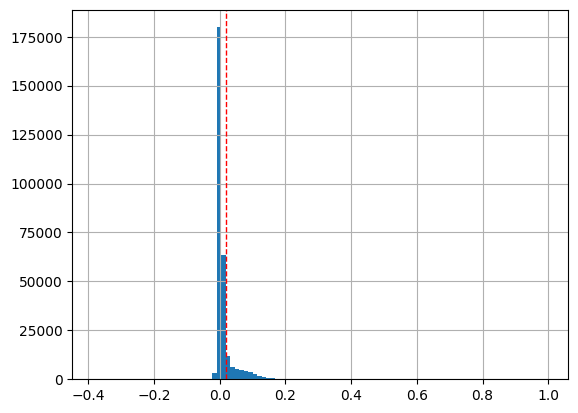

In [71]:
pred_df.similarity.hist(bins=100)
plt.axvline(x=0.02, color='red', linestyle='--', linewidth=1)

In [72]:
def get_FAR_FRR(df, thr=0.5, pred_col='similarity', target_col='is_same_user_device_camera'):
    targets = df[target_col]
    pred_proba = df[pred_col]
    
    preds = pred_proba > thr
    TP = sum((targets == True) & (preds == True))
    FP = sum((targets == False) & (preds == True))
    TN = sum((targets == False) & (preds == False))
    FN = sum((targets == True) & (preds == False))

    if (TN + FP) == 0:
        FAR = None
    else:
        FAR = FP / (TN + FP)

    if (TP + FN) == 0:
        FRR = None
    else:
        FRR = FN / (TP + FN)

    # print(f'FAR: {FAR:.1%}')
    # print(f'FRR: {FRR:.1%}')
    return FAR, FRR


In [125]:
subject_fars = {}
subject_frrs = {}
for subject_name, subject_df in tqdm(pred_df.groupby('enroll_user')):
    fars = []
    frrs = []
    for t in np.arange(0, 0.2, 0.002):
        far, frr = get_FAR_FRR(subject_df, t)
        fars.append(far)
        frrs.append(frr)
    subject_fars[subject_name] = fars
    subject_frrs[subject_name] = frrs


  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: >

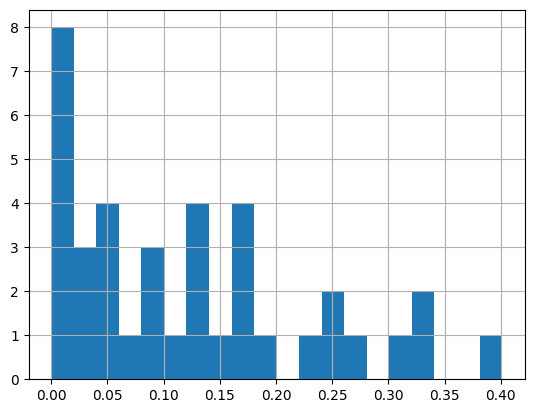

In [126]:
pd.DataFrame(subject_frrs).iloc[0].hist(bins=20)

In [127]:
idx = 0
fars_per_user = pd.DataFrame(subject_fars).iloc[idx]#.sort_values().apply(lambda x: f"{x:.1%}" if x else 'N/A')
frrs_per_user = pd.DataFrame(subject_frrs).iloc[idx]#.sort_values().apply(lambda x: f"{x:.1%}" if x else 'N/A')
far_frr_merged = pd.concat([fars_per_user.sort_index(), frrs_per_user.sort_index() ], axis=1)
far_frr_merged.columns=['FAR', 'FRR']
mask = (~far_frr_merged.isna()).min(axis=1)
display(far_frr_merged[mask].mean().map(lambda x: f"{x:.1%}" if x is not None else 'N/A'))
far_frr_merged[mask].sort_values(by='FRR').map(lambda x: f"{x:.1%}" if x is not None else 'N/A')

FAR    72.9%
FRR    12.3%
dtype: object

,FAR,FRR
gabriele.paolocci@keyless.io,75.0%,0.0%
alessandro.dangeli@keyless.io,100.0%,0.0%
alex.jones@keyless.io,64.3%,0.0%
mathias.hoellerl@keyless.io,94.1%,0.0%
francesco@keyless.io,100.0%,0.0%
dean.stevenson@keyless.io,61.9%,0.0%
ali.nazem@keyless.io,98.5%,0.6%
ahmed.atef@keyless.io,78.9%,1.7%
max@keyless.io,67.5%,2.6%
zac@keyless.io,47.6%,2.8%


In [128]:
frrs = pd.DataFrame(subject_frrs).mean(axis=1).values
frrs[:4]

array([0.1233198197916017, 0.1917202757899646, 0.27925647465335013,
       0.3723346151492365], dtype=object)

In [129]:
fars = pd.DataFrame(subject_fars).mean(axis=1).values
fars[:4]

array([0.74236949, 0.58185117, 0.43879413, 0.3396394 ])

In [130]:
def get_closest_to_far(target_far, fars, frrs):
    idx = (np.array(fars) < target_far).argmax()
    return fars[idx], frrs[idx]

def get_closest_to_frr(target_frr, fars, frrs):
    idx = (np.array(frrs) > target_frr).argmax()
    print(idx)
    return fars[idx], frrs[idx]

0


Text(0.5, 1.0, '12.3% FRR @ 74.2% FAR')

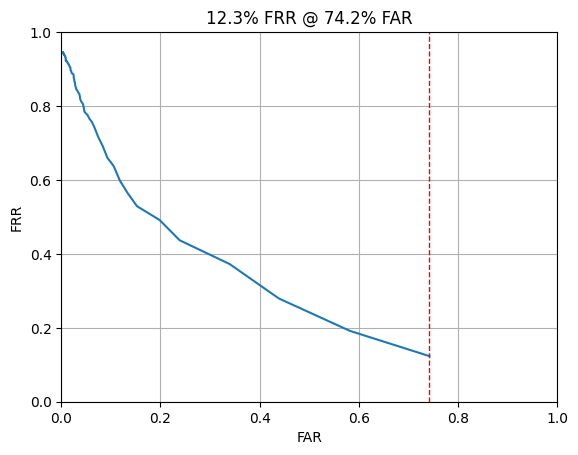

In [131]:

target_frr = 0.08
sel_far, sel_frr = get_closest_to_frr(target_frr, fars, frrs)

plt.plot(fars, frrs)
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(x=sel_far, color='red', linestyle='--', linewidth=1)
plt.title(f'{sel_frr:.1%} FRR @ {sel_far:.1%} FAR')

In [133]:
pred_df.enroll_user_device_camera.nunique()

157